## Second Marshall1994 numerical method : Coalition vs Individuals

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

from tqdm import tqdm_notebook as tqdm
import timeit

In [2]:
def bid1_f(v,method_out) :
    return method_out['tstar']*np.searchsorted(method_out['values1_'],v)/(method_out['N']+1)

def bid2_f(v,method_out) :
    return method_out['tstar']*np.searchsorted(method_out['values2_'],v)/(method_out['N']+1)

In [3]:
def display2(out) :
    plt.figure(figsize=(15,4.5))
    plt.suptitle(r"Coallition $k_1={}$ vs Individuals $k_2={}$".format(out['k1'],out['k2']))
    v_ = np.linspace(0,1,1001)
    
    plt.subplot(131)
    plt.plot(np.linspace(0,out['tstar'],out['N']+2),out['delta1_'],'b',label=r'$\delta_1$')
    plt.plot(np.linspace(0,out['tstar'],out['N']+2),out['delta2_'],'r',label=r'$\delta_2$')
    plt.axhline(out['l1'],color='b',linestyle='--')
    plt.axhline(1/out['tstar'],color='gray',linestyle='--')
    plt.axhline(out['l2'],color='r',linestyle='--')
    #plt.ylim((min(out['l2'],out['l1'])-0.1,max(out['l2'],out['l1'])+0.1))
    
    plt.axvline(out['tstar']*out['breakpoint']/(out['N']+1),color='k',linewidth=2)
    
    plt.title(r"Approximated functions : $\delta_i(b) = \lambda_i(b)/b$")
    plt.legend()
    
    
    plt.subplot(132)
    b_ = np.linspace(0,out['tstar'],out['N']+2)
    plt.plot(b_,out['values1_'],'b',label=r'$\lambda_1$')
    plt.plot(b_,out['values2_'],'r',label=r'$\lambda_2$')
    plt.plot(b_,out['l1']*b_,'b--')
    plt.plot(b_,out['l2']*b_,'r--')
    
    plt.title(r"Value functions $\lambda_i$")
    plt.legend()
    plt.xlim((0,out['tstar']))
    plt.grid(True, which='both')
    
    
    plt.subplot(133)
    plt.plot(v_,[bid1_f(v,out) for v in v_],'b',label=r"$\phi_1$")
    plt.plot(v_,[bid2_f(v,out) for v in v_],'r',label=r"$\phi_2$")
    plt.plot(v_,1/out['l1']*v_,'b--')
    plt.plot(v_,1/out['l2']*v_,'r--')
    plt.axhline(out['tstar'],color='gray',linestyle='--')
    
    plt.title(r"Bid functions $\phi_i$")
    plt.legend()
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.grid(True, which='both')
    
    plt.show()

In [4]:
def marshall2_sub_method(tstar,k1,k2,N=10_000,p=5,correct=True) :
    delta1_ = np.zeros(N+2)
    delta2_ = np.zeros(N+2)
    
    l1 = 1+1/k2
    l2 = 1+1/(k1+k2-1)
    
    output = {}
    output['tstar'] = tstar
    output['N']=N
    output['breakpoint'] = 0
    output['l1'] = l1
    output['l2'] = l2
    output['k1'] = k1
    output['k2'] = k2
    
    a_ = np.zeros(p+1)
    b_ = np.zeros(p+1)
    c_ = np.zeros(p+1)
    alpha_ = np.zeros(p+1)
    beta_ = np.zeros(p+1)
    gamma_ = np.zeros(p+1)
    
    theta = (k2-1)/k1
    
    delta1_[N+1] = 1/tstar
    delta2_[N+1] = 1/tstar
    
    for j in np.arange(N+1,0,-1) : #j=N+1,...,1
        tj = tstar*j/(N+1)
                    
        #values at tj, equations (17 (modified, see 26), 36, 37)
        b_[0] = delta2_[j]
        
        #c_[0] = (delta1_[j]**(k1/(k1+k2-1)))*(delta2_[j]**((k2-1)/(k1+k2-1)))
        #a_[0] = c_[0]*(c_[0]/b_[0])**theta
        
        a_[0] = delta1_[j]
        c_[0] = np.power(a_[0],k1/(k1+k2-1))*np.power(b_[0],(k2-1)/(k1+k2-1))
        
        alpha_[0] = a_[0]*c_[0]
        beta_[0] = b_[0]*c_[0]
        gamma_[0] = a_[0]*b_[0]
        
        ## updating the Taylors approximations equations (16, 33, 34, 35)
        for l in range(p) :
            sum_b = np.sum([i*a_[l+1-i]*( b_[i-1]+tj*b_[i]) for i in range(1,l+1)])    
            b_[l+1] = -b_[l]/tj + 1/((l+1)*(a_[0]-1)*tj) * ( (1/k2)*b_[l]-sum_b )
        
            sum_c = np.sum([i*b_[l+1-i]*( c_[i-1]+tj*c_[i]) for i in range(1,l+1)])
            c_[l+1] = -c_[l]/tj + 1/((l+1)*(b_[0]-1)*tj) * ( (1/(k1+k2-1))*c_[l]-sum_c )
            
            A = np.sum([i*c_[i]*gamma_[l+1-i]-a_[i]*beta_[l+1-i] for i in range(1,l+1)]) 
            B = theta*np.sum([i*c_[i]*gamma_[l+1-i]-b_[i]*alpha_[l+1-i] for i in range(1,l+1)])
            a_[l+1] = c_[l+1]*alpha_[0]/beta_[0]+theta*(c_[l+1]*alpha_[0]/beta_[0]-b_[l+1]*alpha_[0]/beta_[0])+1/((l+1)*beta_[0]) * (A+B)
            
            alpha_[l+1] = np.sum([a_[i]*c_[l+1-i] for i in range(0,l+2)]) 
            beta_[l+1] = np.sum([b_[i]*c_[l+1-i] for i in range(0,l+2)]) 
            gamma_[l+1] = np.sum([a_[i]*b_[l+1-i] for i in range(0,l+2)])       
        
        tjm1 = tstar*(j-1)/(N+1)
        
        delta1_[j-1] = np.polynomial.polynomial.polyval(tjm1-tj,a_) #updating at tj-1
        delta2_[j-1] = np.polynomial.polynomial.polyval(tjm1-tj,b_)
        
        if(output['breakpoint'] == 0 and ((delta1_[j-1]-l1)**2+(delta2_[j-1]-l2)**2 > ((delta1_[j]-l1)**2+(delta2_[j]-l2)**2))) :
            output['breakpoint'] = j
            if(correct) :
                break
    
    output['eps_star'] = np.sqrt(((delta1_[output['breakpoint']]-l1)**2+(delta2_[output['breakpoint']]-l2)**2))
    #output['precision'] = np.min(((delta1_-l1)**2+(delta2_-l2)**2))
    if(correct) :
        ind = output['breakpoint']
        delta1_[:ind+1] = np.linspace(l1,delta1_[ind],ind+1)
        delta2_[:ind+1] = np.linspace(l2,delta2_[ind],ind+1)
        
        #patch_ = 1/(np.linspace(0,out['tstar'],out['N']+2)[1:])
        #delta1_[1:] = np.where(delta1_[1:] > patch_, patch_,delta1_[1:])
        #delta2_[1:] = np.where(delta2_[1:] > patch_, patch_,delta2_[1:])
        
    output['delta1_']=delta1_
    output['delta2_']=delta2_
    output['values1_']=np.linspace(0,tstar,N+2)*delta1_
    output['values2_']=np.linspace(0,tstar,N+2)*delta2_
    return output

In [5]:
def marshall2_iterative_find_boundary_CUSTOM(k1,k2,eps=10**-5,nb_eval_max=500,N=10_000,p=5,show_msg=False) :
    l1 = 1+1/k2
    l2 = 1+1/(k1+k2-1)
    
    a = 1/l1
    b = 1/l2
    
    tau = (np.sqrt(5)-1)/2
    
    x_1 = a + (1-tau)*(b-a)
    f_1 = marshall2_sub_method(x_1,k1,k2,N,p,correct=True)
    
    x_2 = a + tau*(b-a)
    f_2 = marshall2_sub_method(x_2,k1,k2,N,p,correct=True)
    
    i=2
    while(f_1['eps_star']>eps and f_2['eps_star']>eps and i < nb_eval_max) :
        if(f_1['eps_star'] > f_2['eps_star']) :
            a = x_1
            x_1 = x_2
            f_1 = f_2
            x_2 = a + tau*(b-a)
            f_2 = marshall2_sub_method(x_2,k1,k2,N,p,correct=True)
        else :
            b = x_2
            x_2 = x_1
            f_2 = f_1
            x_1 = a + (1-tau)*(b-a)
            f_1 = marshall2_sub_method(x_1,k1,k2,N,p,correct=True)
        i+=1
    
    if(show_msg) :
        print("Nb of eval :",i)
        print("eps_star :",min(f_1['eps_star'],f_2['eps_star']))
        if(i==nb_eval_max) :
            print("Maximum number of evaluations reached")
            
    if(f_1['eps_star']<f_2['eps_star']) :
        return f_1
    else :
        return f_2

In [6]:
def marshall2_iterative_find_boundary_OPTIMIZE(k1,k2,method="bounded",maxiter=500,N=10_000,p=5,show_msg=False,correct=True) :
    l1 = 1+1/k2
    l2 = 1+1/(k1+k2-1)
    
    lb = 1/l1
    ub = 1/l2
    
    precision_function = lambda tstar:marshall2_sub_method(tstar,k1,k2,N=N,p=p,correct=True)['eps_star']
    
    opt = optimize.minimize_scalar(precision_function,method=method,bracket=(lb,ub),bounds=(lb,ub),options={'maxiter':maxiter})
    if(show_msg) :
        print(opt)
    return marshall2_sub_method(opt.x,k1,k2,N=N,p=p,correct=correct)

### Custom tests

Nb of eval : 2
eps_star : 0.0
tstar : 0.8


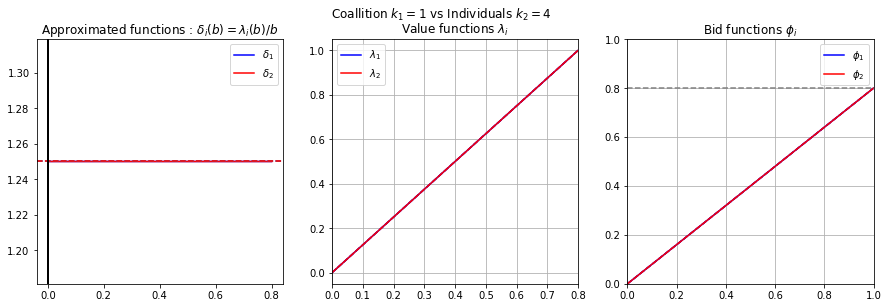

Nb of eval : 17
eps_star : 2.1812080450826656e-06
tstar : 0.7832902265133334


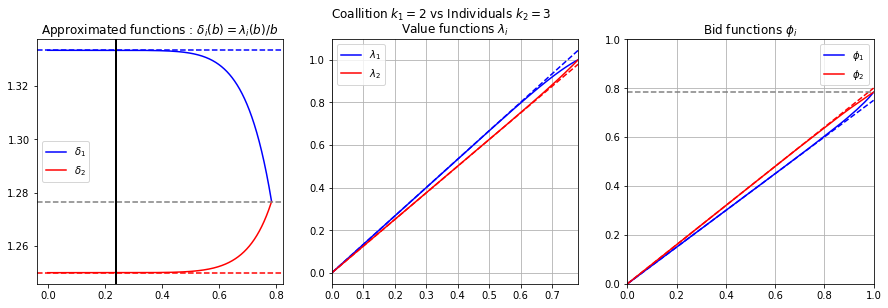

Nb of eval : 37
eps_star : 6.1182792230982745e-06
tstar : 0.7424021434342534


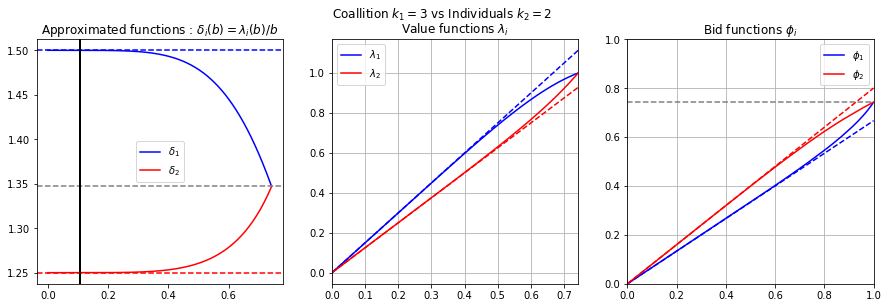

Nb of eval : 45
eps_star : 7.2575090683245236e-06
tstar : 0.6433802165625286


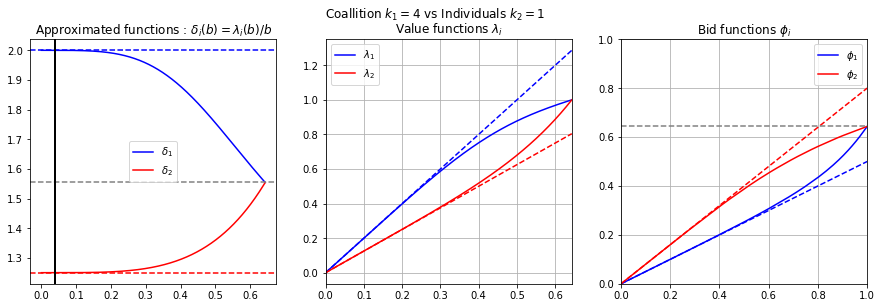

Nb of eval : 38
eps_star : 5.859989948518427e-06
tstar : 0.8471716369280046


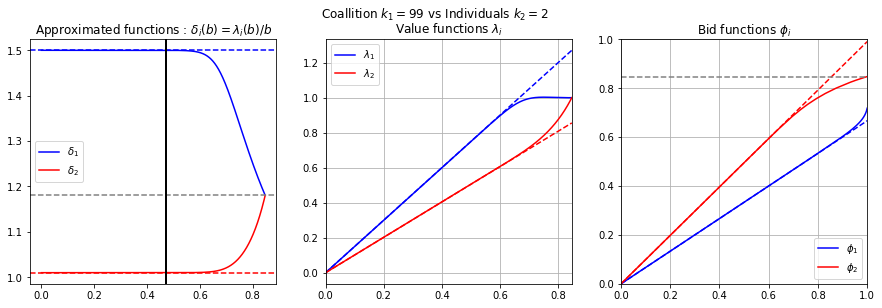

In [10]:
 for (k1,k2) in [(1,4),(2,3),(3,2),(4,1),(99,2)] :
    out = marshall2_iterative_find_boundary_CUSTOM(k1,k2,eps=10**-5,p=1,show_msg=True)
    print("tstar :",out['tstar'])
    display2(out)

----

Nb of eval : 45
eps_star : 7.2575090683245236e-06
{'tstar': 0.6433802165625286, 'N': 10000, 'breakpoint': 592, 'l1': 2.0, 'l2': 1.25, 'k1': 4, 'k2': 1, 'eps_star': 7.2575090683245236e-06, 'delta1_': array([2.        , 2.        , 2.        , ..., 1.55446152, 1.55437619,
       1.55429088]), 'delta2_': array([1.25      , 1.25000001, 1.25000002, ..., 1.55404098, 1.55416591,
       1.55429088]), 'values1_': array([0.00000000e+00, 1.28663177e-04, 2.57326354e-04, ...,
       9.99909787e-01, 9.99954896e-01, 1.00000000e+00]), 'values2_': array([0.00000000e+00, 8.04144864e-05, 1.60828974e-04, ...,
       9.99639273e-01, 9.99819615e-01, 1.00000000e+00])}


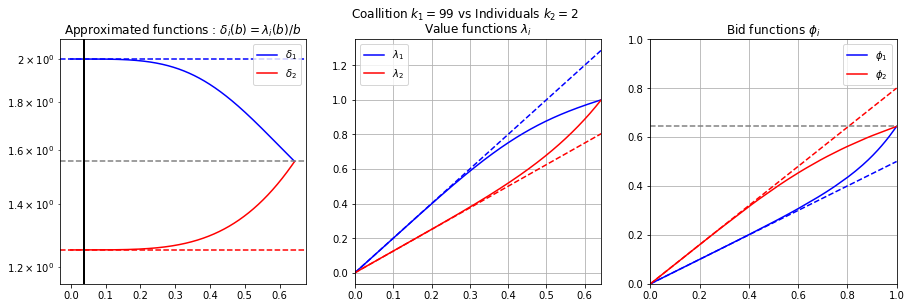

In [52]:
out = marshall2_iterative_find_boundary_CUSTOM(4,1,eps=10**-5,p=1,show_msg=True)
print(out)
display(out)

Nb of eval : 45
eps_star : 7.2575090683245236e-06
{'tstar': 0.6433802165625286, 'N': 10000, 'breakpoint': 592, 'l1': 2.0, 'l2': 1.25, 'k1': 4, 'k2': 1, 'eps_star': 7.2575090683245236e-06, 'delta1_': array([2.        , 2.        , 2.        , ..., 1.55446152, 1.55437619,
       1.55429088]), 'delta2_': array([1.25      , 1.25000001, 1.25000002, ..., 1.55404098, 1.55416591,
       1.55429088]), 'values1_': array([0.00000000e+00, 1.28663177e-04, 2.57326354e-04, ...,
       9.99909787e-01, 9.99954896e-01, 1.00000000e+00]), 'values2_': array([0.00000000e+00, 8.04144864e-05, 1.60828974e-04, ...,
       9.99639273e-01, 9.99819615e-01, 1.00000000e+00])}


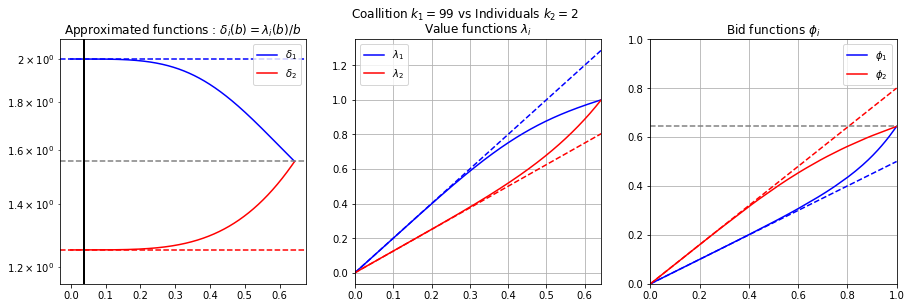

In [48]:
out = marshall2_iterative_find_boundary_CUSTOM(4,1,eps=10**-5,p=1,show_msg=True)
print(out)
display(out)

Nb of eval : 42
eps_star : 9.294231915637422e-06
{'tstar': 0.746859107536968, 'N': 10000, 'breakpoint': 4112, 'l1': 2.0, 'l2': 1.02, 'k1': 50, 'k2': 1, 'eps_star': 9.294231915637422e-06, 'delta1_': array([2.        , 2.        , 2.        , ..., 1.33919264, 1.33906661,
       1.33894062]), 'delta2_': array([1.02      , 1.02      , 1.02      , ..., 1.33841856, 1.33867951,
       1.33894062]), 'values1_': array([0.00000000e+00, 1.49356886e-04, 2.98713772e-04, ...,
       9.99988203e-01, 9.99994090e-01, 1.00000000e+00]), 'values2_': array([0.00000000e+00, 7.61720119e-05, 1.52344024e-04, ...,
       9.99410191e-01, 9.99705012e-01, 1.00000000e+00])}


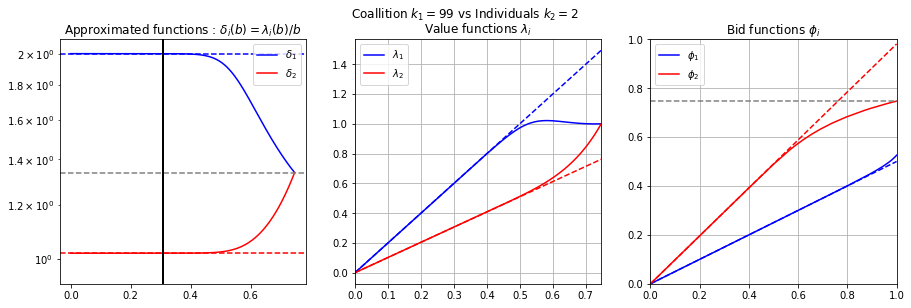

In [47]:
out = marshall2_iterative_find_boundary_CUSTOM(50,1,eps=10**-5,p=1,show_msg=True)
print(out)
display(out)

## Tests - close form boundary $t_*$

In [ ]:
for (k1,k2,tstar) in [(1,4,0.8),(2,3,0.78324204),(3,2,0.74169876),(4,1,0.63737587),(99,2,0.84113794)] :

    out = marshall2_sub_method(tstar,k1,k2,correct=False)
    #print('Approximate boundary',out['tstar'])
    print('Boundary from Marshall1994',tstar)
    print('eps_star',out['eps_star'])
        
    display(out)

In [ ]:
for (k1,k2,tstar) in [(1,4,0.8),(2,3,0.78324204),(3,2,0.74169876),(4,1,0.63737587),(99,2,0.84113794)] :

    out = marshall2_sub_method(tstar,k1,k2,correct=True)
    #print('Approximate boundary',out['tstar'])
    print('Boundary from Marshall1994',tstar)
    print('eps_star',out['eps_star'])
        
    display(out)

## Tests - search boundary $t_*$

In [ ]:
for (k1,k2,tstar) in [(1,4,0.8),(2,3,0.78324204),(3,2,0.74169876),(4,1,0.63737587),(99,2,0.84113794)] :
    out = marshall2_iterative_find_boundary_OPTIMIZE(k1,k2,correct=True,show_msg=True)
    
    print()
    print('Approximate boundary', out['tstar'])
    print('Boundary from Marshall1994', tstar)
    print('eps_star',out['eps_star'])
    
    display(out)

In [ ]:
for (k1,k2,tstar) in [(1,4,0.8),(2,3,0.78324204),(3,2,0.74169876),(4,1,0.63737587),(99,2,0.84113794)] :
    l1 = 1+1/k2
    l2 = 1+1/(k1+k2-1)

    out = marshall2_iterative_find_boundary_CUSTOM(k1,k2,eps=10**-5,show_msg=True)
    
    print()
    print('Approximate boundary', out['tstar'])
    print('Boundary from Marshall1994', tstar)
    print('eps_star',out['eps_star'])
    
    display(out)

In [ ]:
for (k1,k2,tstar) in [(1,4,0.8),(2,3,0.78324204),(3,2,0.74169876),(4,1,0.63737587),(99,2,0.84113794)] :
    l1 = 1+1/k2
    l2 = 1+1/(k1+k2-1)

    out = marshall2_iterative_find_boundary_OPTIMIZE(k1,k2,correct=False,show_msg=True)
    
    print()
    print('Approximate boundary',out['tstar'])
    print('Boundary from Marshall1994',tstar)
    print('eps_star',out['eps_star'])
    
    display(out)